In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from autograd import grad

In [11]:
# dados tratados de dengue 
df_dengue = pd.read_csv(
    'data/casos_dengues/sinannet_cnv_denguebam144818186_232_61_4.csv',
    sep=';',  
    encoding='latin1' 
)

df_dengue.replace(np.nan,0)

# Renomeando as colunas
df_dengue.columns=[
    'Ano', "Rio Negro", "Japura", "Alto Solimoes", "Juruá", "Tefé", 
    "Coari", "Manaus", "Rio Preto da Eva", "Itacoatiara", "Parintins", 
    "Boca do Acre", "Purus", "Madeira", "Total"
]
# Colunas de interesse
df_dengue = df_dengue[['Ano','Manaus', 'Itacoatiara']]

df_dengue


,Ano,Manaus,Itacoatiara
0,2020,972,19
1,2021,4465,14
2,2022,1255,13
3,2023,1314,4
4,2024,2634,28


In [12]:
# dados meteorologico
df_clima_Manaus = pd.read_csv(
    'data/meteorologicos/$2a$10$AaYjB4aQ4cPYkk.YpxaMW.Lt5MJ2oMB0ZAXdRQ55GckckJutnkpWy/Manaus.csv',
    sep=';', encoding='utf-8'
)
df_clima_Itacoatiara = pd.read_csv(
    'data/meteorologicos/$2a$10$AaYjB4aQ4cPYkk.YpxaMW.Lt5MJ2oMB0ZAXdRQ55GckckJutnkpWy/Itacoatiara.csv',
    sep=';', encoding='utf-8'
)

# Renomear as colunas de precipitação para identificar cada cidade
df_clima_Manaus.rename(columns={'PRECIPITACAO TOTAL': 'PRECIPITACAO_MANAUS'}, inplace=True)
df_clima_Itacoatiara.rename(columns={'PRECIPITACAO TOTAL, MENSAL(mm)': 'PRECIPITACAO_ITACOATIARA'}, inplace=True)


# Mesclar os DataFrames pela coluna 'Data Medicao'
df_clima = pd.merge(df_clima_Manaus, df_clima_Itacoatiara, on='Data Medicao', how='outer')

# Remover colunas desnecessárias
df_clima.drop(columns=['Unnamed: 2_x', 'Unnamed: 2_y'], inplace=True)

# Converter a coluna de data para datetime
df_clima['Data Medicao'] = pd.to_datetime(df_clima['Data Medicao'])

# Extrair o ano
df_clima['Ano'] = df_clima['Data Medicao'].dt.year

# Calcular a precipitação anual por cidade
precipitacao_anual = df_clima.groupby('Ano')[['PRECIPITACAO_MANAUS', 'PRECIPITACAO_ITACOATIARA']].sum()
precipitacao_anual = precipitacao_anual.reset_index()

precipitacao_anual

,Ano,PRECIPITACAO_MANAUS,PRECIPITACAO_ITACOATIARA
0,2020,3134.6,2212.3
1,2021,2231.3,3033.3
2,2022,2535.8,2977.3
3,2023,2338.7,1217.9
4,2024,1790.8,234.5


In [13]:
# Juntar dados de dengue e precipitação para cada cidade
df_manaus = pd.merge(df_dengue[['Ano', 'Manaus']], precipitacao_anual[['Ano','PRECIPITACAO_MANAUS']], on='Ano')
df_manaus.rename(columns={'Manaus': 'casos_dengue'}, inplace=True)

df_itacoatiara = pd.merge(df_dengue[['Ano', 'Itacoatiara']], precipitacao_anual[['Ano','PRECIPITACAO_ITACOATIARA']], on='Ano')
df_itacoatiara.rename(columns={'Itacoatiara': 'casos_dengue'}, inplace=True)

df_itacoatiara

,Ano,casos_dengue,PRECIPITACAO_ITACOATIARA
0,2020,19,2212.3
1,2021,14,3033.3
2,2022,13,2977.3
3,2023,4,1217.9
4,2024,28,234.5


In [14]:
df_manaus

,Ano,casos_dengue,PRECIPITACAO_MANAUS
0,2020,972,3134.6
1,2021,4465,2231.3
2,2022,1255,2535.8
3,2023,1314,2338.7
4,2024,2634,1790.8


In [15]:
# Funções de predição linear e treinamento

# Normalizar os dados
# Função para normalizar os dados
def normalize_data(X, y):
    X_mean, X_std = X.mean(), X.std()  # Calcular média e desvio padrão de X
    y_mean, y_std = y.mean(), y.std()  # Calcular média e desvio padrão de y
    X_normalized = (X - X_mean) / X_std
    y_normalized = (y - y_mean) / y_std
    return X_normalized, y_normalized, X_mean, X_std, y_mean, y_std

def predict(weights, x):
    return np.dot(x, weights)

def mse(weights, x, y):
    predictions = predict(weights, x)
    return np.mean((predictions - y) ** 2)

# Função para calcular o gradiente manualmente
def grad_mse(weights, x, y):
    predictions = predict(weights, x)
    return (2 / len(x)) * np.dot(x.T, (predictions - y))

# Função de treinamento do modelo
def train_model(X_train, y_train, learning_rate=0.01, epochs=10000):
    weights = np.zeros(X_train.shape[1])  # Inicializar os pesos com zeros

    for epoch in range(epochs):
        gradients = grad_mse(weights, X_train, y_train)  # Calcular o gradiente manualmente
        weights -= learning_rate * gradients  # Atualizar os pesos com descida do gradiente
        if epoch % 1000 == 0:
            loss = mse(weights, X_train, y_train)
            print(f"Epoch {epoch}, Loss: {loss}")
    return weights

def predict_2024(weights, X_mean, X_std, y_mean, y_std, df, cidade):
    try:
        precipitacao_2024 = df.loc[df['Ano'] == 2024, f'PRECIPITACAO_{cidade.upper()}'].values[0]
        precipitacao_2024_normalizada = (precipitacao_2024 - X_mean) / X_std
        previsao_normalizada_2024 = predict(weights, [precipitacao_2024_normalizada])
        previsao_2024 = previsao_normalizada_2024 * y_std + y_mean
        print(f'Previsão de casos de dengue para 2024 em {cidade}: {previsao_2024}')
    except IndexError:
        print(f"Dados de precipitação para 2024 não encontrados para {cidade}")

In [16]:
def plot_results(y_test_desnormalized, y_pred_test, cidade):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test_desnormalized)), y_test_desnormalized, label='Valores Reais')
    plt.plot(range(len(y_pred_test)), y_pred_test, label='Predições do Modelo', color='red')
    plt.xlabel('Período')
    plt.ylabel('Casos de Dengue')
    plt.title(f'Predição de Casos de Dengue em {cidade}')
    plt.legend()
    plt.show()

In [17]:
def train_and_predict(df, cidade):
    X = df[[f'PRECIPITACAO_{cidade.upper()}']].values
    y = df['casos_dengue'].values
    X_normalized, y_normalized, X_mean, X_std, y_mean, y_std = normalize_data(X, y)
    split_index = int(0.7 * len(X_normalized))
    X_train, X_test = X_normalized[:split_index], X_normalized[split_index:]
    y_train, y_test = y_normalized[:split_index], y_normalized[split_index:]
    weights = train_model(X_train, y_train)
    y_pred_test_normalized = predict(weights, X_test)
    y_pred_test = y_pred_test_normalized * y_std + y_mean
    y_test_desnormalized = y_test * y_std + y_mean
    plot_results(y_test_desnormalized, y_pred_test, cidade)
    predict_2024(weights, X_mean, X_std, y_mean, y_std, df, cidade)

Epoch 0, Loss: 1.4609815470665293
Epoch 1000, Loss: 0.8533123058981779
Epoch 2000, Loss: 0.8533123058981779
Epoch 3000, Loss: 0.8533123058981779
Epoch 4000, Loss: 0.8533123058981779
Epoch 5000, Loss: 0.8533123058981779
Epoch 6000, Loss: 0.8533123058981779
Epoch 7000, Loss: 0.8533123058981779
Epoch 8000, Loss: 0.8533123058981779
Epoch 9000, Loss: 0.8533123058981779


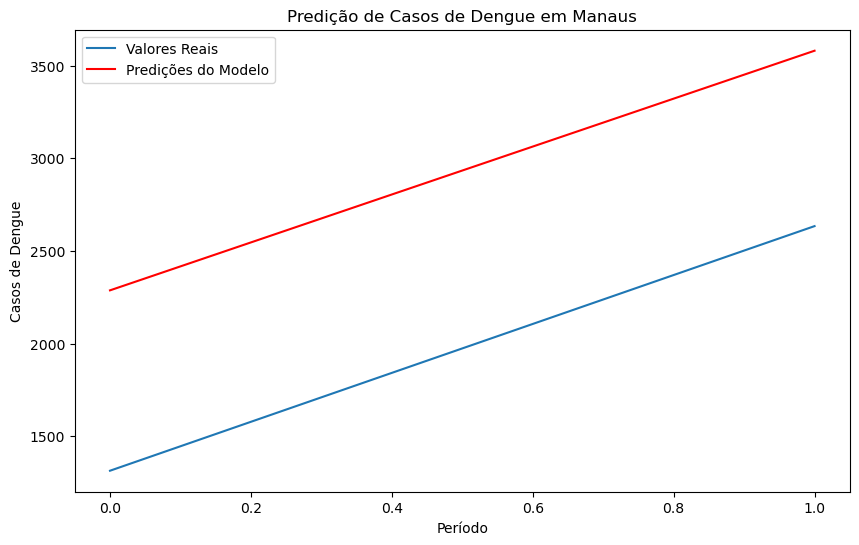

Previsão de casos de dengue para 2024 em Manaus: 3580.5292787676294
Epoch 0, Loss: 0.1117809408489251
Epoch 1000, Loss: 0.08428894911077393
Epoch 2000, Loss: 0.08428894911074375
Epoch 3000, Loss: 0.08428894911074374
Epoch 4000, Loss: 0.08428894911074374
Epoch 5000, Loss: 0.08428894911074374
Epoch 6000, Loss: 0.08428894911074374
Epoch 7000, Loss: 0.08428894911074374
Epoch 8000, Loss: 0.08428894911074374
Epoch 9000, Loss: 0.08428894911074374


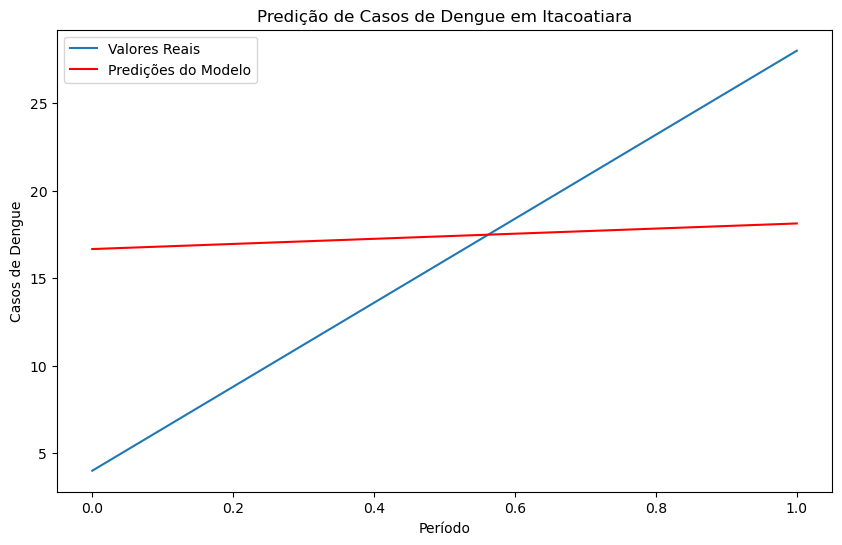

Previsão de casos de dengue para 2024 em Itacoatiara: 18.129670364019468


In [18]:
# Executar treinamento e previsão para Manaus e Itacoatiara
train_and_predict(df_manaus, 'Manaus')
train_and_predict(df_itacoatiara, 'Itacoatiara')